In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyp
import seaborn as sns

In [2]:
ds= pd.read_csv('2019.csv')
ds.head() #test to check if file is readable

Overall rank Country or region  Score  GDP per capita  Social support  \
0             1           Finland  7.769           1.340           1.587   
1             2           Denmark  7.600           1.383           1.573   
2             3            Norway  7.554           1.488           1.582   
3             4           Iceland  7.494           1.380           1.624   
4             5       Netherlands  7.488           1.396           1.522   

   Healthy life expectancy  Freedom to make life choices  Generosity  \
0                    0.986                         0.596       0.153   
1                    0.996                         0.592       0.252   
2                    1.028                         0.603       0.271   
3                    1.026                         0.591       0.354   
4                    0.999                         0.557       0.322   

   Perceptions of corruption  
0                      0.393  
1                      0.410  
2                      0.341  
3                      0.118  
4                      0.298

In [4]:
#check how many empty values are there
ds.isna().sum() #it is not neccessary to do delete or fill in the NaN values

Overall rank                    0
Country or region               0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

In [5]:
#look at the data types to see which columns need to be encoded
ds.dtypes

Overall rank                      int64
Country or region                object
Score                           float64
GDP per capita                  float64
Social support                  float64
Healthy life expectancy         float64
Freedom to make life choices    float64
Generosity                      float64
Perceptions of corruption       float64
dtype: object

<AxesSubplot:>

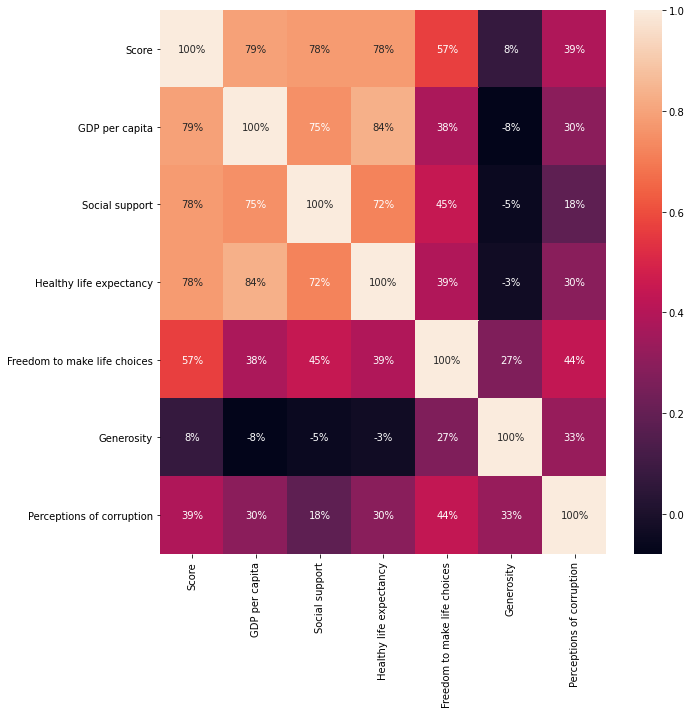

In [6]:
#Finding highly correlated attributes
pyp.figure(figsize=(10,10))
sns.heatmap(ds.iloc[:,2:9].corr(), annot=True, fmt='.0%')

In [7]:
#Visualize happiness score by country on a world map 
import plotly.graph_objects as go
import  plotly.io as pio
import chart_studio.plotly as py

data = dict(type = 'choropleth', 
           locations = ds['Country or region'],
           locationmode = 'country names',
           z = ds['Score'], 
           text = ds['Country or region'],
           colorbar = {'title':'Happiness'})

layout = dict(title = 'Happiness Index 2019', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))

choromap3 = go.Figure(data = [data], layout=layout)

pio.show(choromap3)

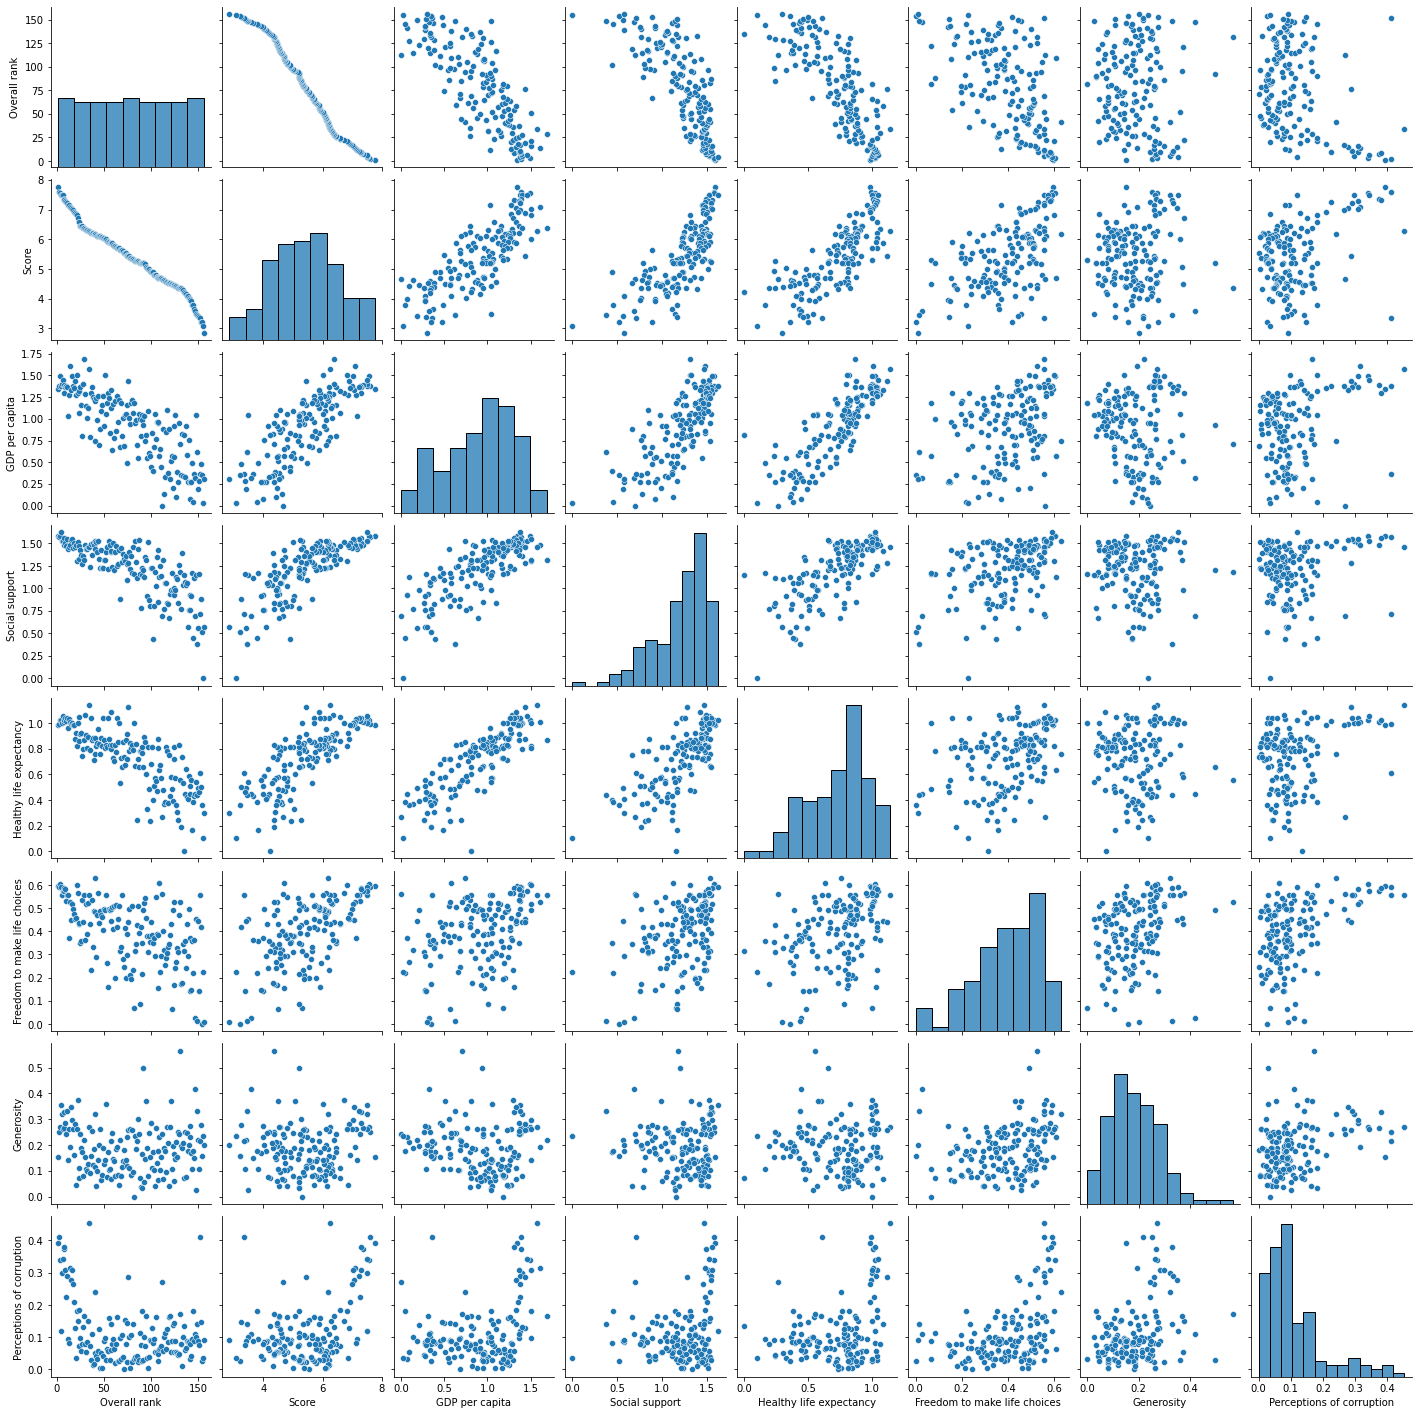

In [8]:
sns.pairplot(ds)

In [9]:
#Scale data to bring all features to the same magnitude
from sklearn.preprocessing import StandardScaler
X = ds.iloc[:,2:9]
sc = StandardScaler()
X = sc.fit_transform(X)

array([[ 2.12871112,  1.09504166,  1.26809758, ...,  1.4242823 ,
        -0.33540398,  2.99675712],
       [ 1.97639663,  1.20332385,  1.22115409, ...,  1.39627687,
         0.70726491,  3.17715844],
       [ 1.93493825,  1.46773387,  1.25133205, ...,  1.47329179,
         0.90737308,  2.4449413 ],
       ...,
       [-1.98648391, -1.39796708, -2.31972634, ..., -2.74852598,
        -0.28274393, -0.90840093],
       [-2.09463621, -2.21386084, -4.05328238, ..., -1.17322084,
         0.52822076, -0.8022825 ],
       [-2.30192812, -1.50876747, -2.12524617, ..., -2.67851242,
         0.18066446, -0.20801932]])

In [10]:
#Variance explained by principal components
from sklearn.decomposition import PCA
pca = PCA(n_components = 7, random_state=100)
pca.fit(X)
X_pca = pca.transform(X)

In [11]:
#Variance ratio for each selected component
np.cumsum(pca.explained_variance_ratio_ * 100)

array([ 54.46491659,  74.85261871,  83.60812259,  91.55536944,
        95.29969682,  97.76121285, 100.        ])

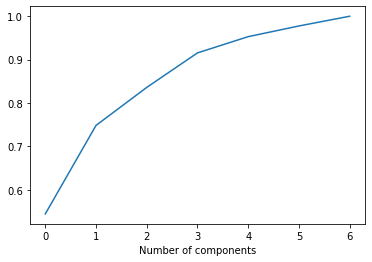

In [12]:
pyp.plot(np.cumsum(pca.explained_variance_ratio_))
pyp.xlabel("Number of components")
pyp.savefig("elbow_plot.png", dpi = 100)

In [13]:
pca_95 = PCA(n_components = 0.95, random_state=100)
pca_95.fit(X)
X_pca_95 = pca_95.transform(X)
X_pca_95.shape

(156, 5)

In [14]:
X = X_pca_95

In [49]:
#Determine the number of clusters for KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sil = []
k_max = 10
for k in range(2, k_max+1):
    k_means = KMeans(n_clusters = k, **kmeans_kwargs).fit(X)
    labels = k_means.labels_
    sil.append(silhouette_score(X, labels, metric = "euclidean"))

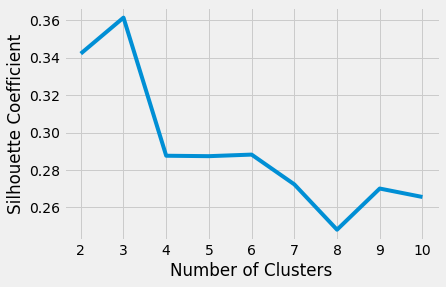

In [16]:
pyp.style.use("fivethirtyeight")
pyp.plot(range(2, 11), sil)
pyp.xticks(range(2, 11))
pyp.xlabel("Number of Clusters")
pyp.ylabel("Silhouette Coefficient")
pyp.show()

In [17]:
#Determine the number of clusters for KMeans
#A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    k_means = KMeans(n_clusters=k, **kmeans_kwargs)
    k_means.fit(X)
    sse.append(k_means.inertia_)

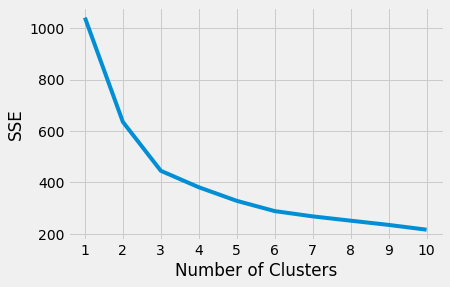

In [18]:
pyp.style.use("fivethirtyeight")
pyp.plot(range(1, 11), sse)
pyp.xticks(range(1, 11))
pyp.xlabel("Number of Clusters")
pyp.ylabel("SSE")
pyp.show()

In [19]:
#Determine what is the elbow
from kneed import KneeLocator
kl = KneeLocator(
 range(1, 11), sse, curve="convex", direction="decreasing"
)
kl.elbow

3

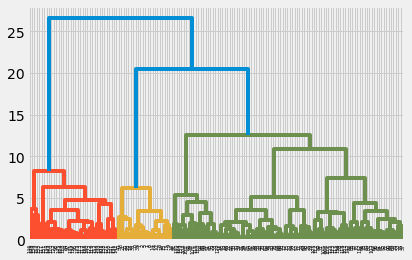

In [20]:
#Determine number of clusters for AgglomerativeClustering
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(X, method = "ward"))

In [50]:
#Determine eps for DBSCAN
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

[[0.         1.05115603]
 [0.         0.57085096]
 [0.         0.31319805]
 [0.         0.82414895]
 [0.         0.15902418]
 [0.         0.31319805]
 [0.         0.44010006]
 [0.         0.70456505]
 [0.         0.45875423]
 [0.         0.5651789 ]
 [0.         0.15902418]
 [0.         0.46188172]
 [0.         0.59164904]
 [0.         0.91913954]
 [0.         0.81248899]
 [0.         0.47556669]
 [0.         0.5651789 ]
 [0.         0.71429285]
 [0.         0.811863  ]
 [0.         0.67946015]
 [0.         0.70863911]
 [0.         0.82414895]
 [0.         0.40093908]
 [0.         0.71429285]
 [0.         0.59164904]
 [0.         0.76719225]
 [0.         0.46435635]
 [0.         0.568274  ]
 [0.         0.70863911]
 [0.         0.76719225]
 [0.         0.27174616]
 [0.         0.49745266]
 [0.         0.42176414]
 [0.         1.01713767]
 [0.         0.49602422]
 [0.         1.02162375]
 [0.         0.85195982]
 [0.         0.8962376 ]
 [0.         0.67720718]
 [0.         0.27174616]


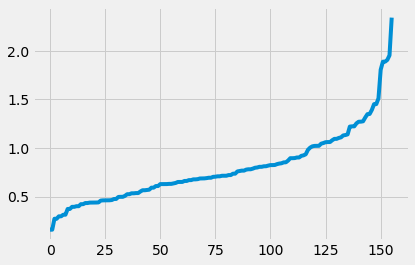

In [25]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
pyp.plot(distances)

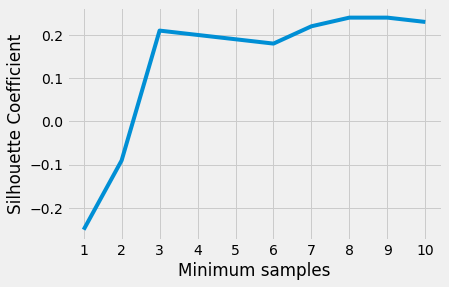

In [31]:
#Determine minSamples for DBSCAN
from sklearn.cluster import DBSCAN

min_samples = []
for m in range(1, 11):
    scan = DBSCAN(eps = 1.25, min_samples = m, n_jobs = -1)
    scan_model = scan.fit(X)
    min_samples.append(silhouette_score(X, scan_model.labels_).round(2))
    
pyp.style.use("fivethirtyeight")
pyp.plot(range(1, 11), min_samples)
pyp.xticks(range(1, 11))
pyp.xlabel("Minimum samples")
pyp.ylabel("Silhouette Coefficient")
pyp.show()

In [32]:
def models(X, nClusters):
    #K-means
    k_means = KMeans(nClusters)
    k_means_model = k_means.fit(X)
    
    #AgglomerativeClustering
    from sklearn.cluster import AgglomerativeClustering
    agg = AgglomerativeClustering(n_clusters = nClusters, affinity='euclidean', linkage='ward')
    agg_model = agg.fit(X)
    
    #MeanShift
    from sklearn.cluster import MeanShift, estimate_bandwidth
    bandwidth = estimate_bandwidth(X, quantile=0.2)
    shift = MeanShift(bandwidth = bandwidth, n_jobs = -1, bin_seeding = True)
    shift_model = shift.fit(X)
    
    #DBSCAN
    scan = DBSCAN(eps = 1.25, min_samples = 3, n_jobs = -1)
    scan_model = scan.fit(X)
    
    print('[0]K-Means: ', silhouette_score(X, k_means_model.labels_).round(2))
    print('[1]Agg: ', silhouette_score(X, agg_model.labels_).round(2))
    print('[2]MeanShift: ', silhouette_score(X, shift_model.labels_).round(2))
    print('[3]DBSCAN: ', silhouette_score(X, scan_model.labels_).round(2))
    
    return k_means_model, agg_model, shift_model, scan_model

In [33]:
model = models(X, 3)

[0]K-Means:  0.36
[1]Agg:  0.33
[2]MeanShift:  0.25
[3]DBSCAN:  0.21


Model  0


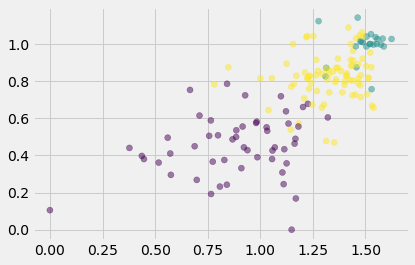


Model  1


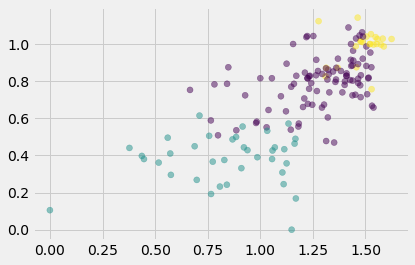


Model  2


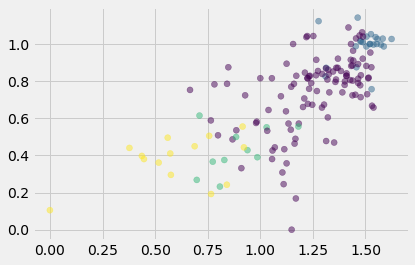


Model  3


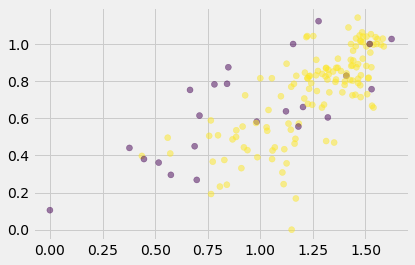

In [48]:
for i in range(len(model)):
    print('Model ', i)
    #Visusalise clusters in 2D 
    X_tmp = ds[["Social support","Healthy life expectancy"]]
    
    pyp.scatter(X_tmp['Social support'], X_tmp['Healthy life expectancy'], c= model[i].labels_.astype(float), alpha=0.5)
    pyp.show()

    #Visualize clusters on world map
    ds["Cluster"] = model[i].labels_
    data = dict(type = 'choropleth', 
               locations = ds['Country or region'],
               locationmode = 'country names',
               z = ds['Cluster'], 
               text = ds['Country or region'],
               colorbar = {'title':'Happiness'})

    layout = dict(title = 'Cluster for model '+ str(i), 
                 geo = dict(showframe = False, 
                           projection = {'type': 'mercator'}))

    choromap3 = go.Figure(data = [data], layout=layout)

    pio.show(choromap3)
    print()